# XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

XGBoost stands for eXtreme Gradient Boosting.

__The XGBoost Advantage__
1.  I’ve always admired the boosting capabilities that this algorithm infuses in a predictive model. When I explored more about its performance and science behind its high accuracy, I discovered many advantages:

- Regularization:
    Standard GBM implementation has no regularization like XGBoost, therefore it also helps to reduce overfitting.In fact, XGBoost is also known as ‘regularized boosting‘ technique.

- Parallel Processing:
    - XGBoost implements parallel processing and is blazingly faster as compared to GBM.
    - But hang on, we know that boosting is sequential process so how can it be parallelized? We know that each tree can be built only after the previous one, so what stops us from making a tree using all cores? I hope you get where I’m coming from. Check this link out to explore further.
    - XGBoost also supports implementation on Hadoop.

- High Flexibility
    - XGBoost allow users to define custom optimization objectives and evaluation criteria.
    -m This adds a whole new dimension to the model and there is no limit to what we can do.

- Handling Missing Values
    - XGBoost has an in-built routine to handle missing values.
    - User is required to supply a different value than other observations and pass that as a parameter. XGBoost tries different things as it encounters a missing value on each node and learns which path to take for missing values in future.
    
- Tree Pruning:
    - A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm.
    - XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
    - Another advantage is that sometimes a split of negative loss say -2 may be followed by a split of positive loss +10. GBM would stop as it encounters -2. But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.
- Built-in Cross-Validation
    - XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.
    - This is unlike GBM where we have to run a grid-search and only a limited values can be tested.
- Continue on Existing Model
    - User can start training an XGBoost model from its last iteration of previous run. This can be of significant advantage in certain specific applications.
    -GBM implementation of sklearn also has this feature so they are even on this point.

## Load Data and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from scipy.stats.stats import pearsonr
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.special import inv_boxcox
from math import sqrt
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import svm
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from numpy import sort

In [2]:
train = pd.read_csv("data/train.csv")
#test = pd.read_csv("data/test.csv")

In [3]:
# to make this notebook's output stable across runs
np.random.seed(42)
random_state = 42

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Data Analysis

In [5]:
print("Train dataset shape : ",train.shape)

Train dataset shape :  (1460, 81)


In [6]:
print("Number of datapoints in the train data set : {} and the number of attributes including label : {}".format(*(train.shape)))
print("Column in the input data : ")
train.info()

Number of datapoints in the train data set : 1460 and the number of attributes including label : 81
Column in the input data : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd

In [7]:
#Look for all columns
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
  

__Observations__ :
-  There are total of 1460 datapoints in training set.
-  There are total of 1459 datapoints in training set.
-  Independent attributes : 80
-  Dependent variable : 1
-  Target/dependent variable is a int
-  There are mix of int & Object datatypes in independent variables.
-  We need to take care of the __null__ values in some independent variables later on.

In [8]:
#look at some sample data
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
#Look for catigorical data
train.nunique()

Id               1460
MSSubClass         15
MSZoning            5
LotFrontage       110
LotArea          1073
Street              2
Alley               2
LotShape            4
LandContour         4
Utilities           2
LotConfig           5
LandSlope           3
Neighborhood       25
Condition1          9
Condition2          8
BldgType            5
HouseStyle          8
OverallQual        10
OverallCond         9
YearBuilt         112
YearRemodAdd       61
RoofStyle           6
RoofMatl            8
Exterior1st        15
Exterior2nd        16
MasVnrType          4
MasVnrArea        327
ExterQual           4
ExterCond           5
Foundation          6
                 ... 
BedroomAbvGr        8
KitchenAbvGr        4
KitchenQual         4
TotRmsAbvGrd       12
Functional          7
Fireplaces          4
FireplaceQu         5
GarageType          6
GarageYrBlt        97
GarageFinish        3
GarageCars          5
GarageArea        441
GarageQual          5
GarageCond          5
PavedDrive

In [10]:
#Analyze the train set from a statistical point
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'], dtype='object')

In [12]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'], dtype='object')

In [13]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  43 categorical + 38 numerical = 81 features


__Observations__ :
-  There are a lot of categoricl values in tthe dataset, as the for many attributes we can see that the unique values are low.
-  The null values are not considered for count

### Create a Test/Train Set

It may sound strange to voluntarily set aside part of the data at this stage. After all, we have only taken a quick glance at the data, and surely we should learn a whole lot more about it before we decide what algorithms to use, right? This is true, but our brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if we look at the test set, we may stumble upon some seemingly interesting pattern in the test data that leads us to select a particular kind of Machine Learning model. When we estimate the generalization error using the test set, our estimate will be too optimistic and we will launch a system that will not perform as well as expected. This is called data snooping bias. Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset, and set them aside:

In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(train, test_size=0.2, random_state=random_state)
print("Train data shape : ", train_set.shape)
print("Test data shape : ", test_set.shape)

Train data shape :  (1168, 81)
Test data shape :  (292, 81)


## Data preparation

### Data Cleaning - Handling Missing Values

Most Machine Learning algorithms cannot work with missing features, so let's create a few functions to take care of them.

__Analyze the frequency of null/nan values__

In [15]:
#Columsn with null/NAN values
train_set_nan_freq = train_set.isnull().sum().to_frame()
train_set_nan_freq['nan_frequency'] = (train_set_nan_freq[0]/train_set.shape[0])*100
train_set_nan_freq.sort_values(by=['nan_frequency'], ascending=False)

,0,nan_frequency
PoolQC,1162,99.486301
MiscFeature,1122,96.061644
Alley,1094,93.664384
Fence,935,80.051370
FireplaceQu,547,46.832192
LotFrontage,217,18.578767
GarageYrBlt,64,5.479452
GarageCond,64,5.479452
GarageType,64,5.479452
GarageFinish,64,5.479452


Now we have to anlyse each and every column to fset missing values.

In [16]:
columns_with_nan = train_set_nan_freq.loc[train_set_nan_freq['nan_frequency']>0].index.tolist()
columns_with_nan

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [17]:
for col in columns_with_nan:
    print("----- Column/Feature Name -----", col)
    if train_set[col].dtypes=='object' :
        print(train_set[col].describe())
    elif train_set[col].dtypes=='int64' or train_set[col].dtypes=='float64' :
        print(train_set[col].describe())

----- Column/Feature Name ----- LotFrontage
count    951.000000
mean      70.343849
std       24.897021
min       21.000000
25%       59.000000
50%       70.000000
75%       80.000000
max      313.000000
Name: LotFrontage, dtype: float64
----- Column/Feature Name ----- Alley
count       74
unique       2
top       Grvl
freq        44
Name: Alley, dtype: object
----- Column/Feature Name ----- MasVnrType
count     1162
unique       4
top       None
freq       677
Name: MasVnrType, dtype: object
----- Column/Feature Name ----- MasVnrArea
count    1162.000000
mean      103.771945
std       173.032238
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1378.000000
Name: MasVnrArea, dtype: float64
----- Column/Feature Name ----- BsmtQual
count     1140
unique       4
top         TA
freq       521
Name: BsmtQual, dtype: object
----- Column/Feature Name ----- BsmtCond
count     1140
unique       4
top         TA
freq      1045
Name: BsmtCond, dtype: obj

Inference of missing values:-
1. FireplaceQu - Set to most occurance category __Gd__ 
2. LotFrontage - Set to mean of __70.343849__
3. GarageType - Set to most occurance category __Attchd__  
4. GarageYrBlt - Set to mean of __1978.662138__ 
5. GarageFinish - Set to most occurance category __Unf__
6. GarageQual - Set to most occurance category __TA__  
7. GarageCond - Set to most occurance category __TA__  
8. BsmtExposure - Set to most occurance category __No__
9. BsmtQual - Set to most occurance category __TA__    
10. BsmtCond - Set to most occurance category __TA__    
11. BsmtFinType1 - Set to most occurance category __Unf__
12. BsmtFinType2 - Set to most occurance category __Unf__
13. MasVnrArea - Set to mean of __103.771945__
14. MasVnrType - Set to most occurance category __None__
16. Electrical - Set to most occurance category __SBrkr__
17. PoolQC - __Drop__, too many null values
18. MiscFeature - __Drop__, too many null values
19. Alley - __Drop__, too many null values
20. Fence - __Drop__, too many null values

__The missing categorical(String) values can be handles in following ways:- __
1. Replace with the most common value for the feature.
2. Replace with Unknown, which will also become a new category.
3. Consider the rows that have the value as training set & the ones not having the value as test set. Then train a KNN to find the missing value.

__The missing numeric values can be handles in following ways:- __
1. Mean
2. SD
3. Replace with the most common value for the feature.

In [18]:
#Dropping above columns from dataset.
train_set.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

/Users/samyam/anaconda3/envs/deeplog/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Impute Missing Values

Any imputing performed on the training dataset will have to be performed on new data in the future when predictions are needed from the finalized model. This needs to be taken into consideration when choosing how to impute the missing values.

For example, if you choose to impute with mean column values, these mean column values will need to be stored to file for later use on new data that has missing values.

In [19]:
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

    
    
train_set_with_nan = train_set[['LotFrontage','GarageYrBlt','MasVnrArea',
                                        'FireplaceQu','GarageType','GarageFinish',
                                        'GarageQual','GarageCond','BsmtExposure','BsmtQual','BsmtCond',
                                        'BsmtFinType1','BsmtFinType2','MasVnrType','Electrical']]   
train_set_without_nan = DataFrameImputer().fit_transform(train_set_with_nan)


#Remove imputed columns from train set
train_set.drop(['LotFrontage','GarageYrBlt','MasVnrArea','FireplaceQu','GarageType','GarageFinish',
                'GarageQual','GarageCond','BsmtExposure','BsmtQual','BsmtCond',
                'BsmtFinType1','BsmtFinType2','MasVnrType','Electrical'], axis=1, inplace=True)

#Concate same coulmns with imputed values
train_set_imputed = pd.concat([train_set,train_set_without_nan],axis=1)

/Users/samyam/anaconda3/envs/deeplog/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
#Verify that missing values are taken care off : Columsn with null/NAN values
train_set_imputed_freq = train_set_imputed.isnull().sum().to_frame()
train_set_imputed_freq['nan_frequency'] = (train_set_imputed_freq[0]/train_set_imputed_freq.shape[0])*100
train_set_imputed_freq.sort_values(by=['nan_frequency'], ascending=False)

,0,nan_frequency
Id,0,0.0
PavedDrive,0,0.0
MiscVal,0,0.0
PoolArea,0,0.0
ScreenPorch,0,0.0
3SsnPorch,0,0.0
EnclosedPorch,0,0.0
OpenPorchSF,0,0.0
WoodDeckSF,0,0.0
GarageArea,0,0.0


__All nan values in data is taken care by diffent strategies__

### Prepare Test dataset

In [21]:
#Dropping above columns from dataset.
test_set.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

test_set_with_nan = test_set[['LotFrontage','GarageYrBlt','MasVnrArea',
                                        'FireplaceQu','GarageType','GarageFinish',
                                        'GarageQual','GarageCond','BsmtExposure','BsmtQual','BsmtCond',
                                        'BsmtFinType1','BsmtFinType2','MasVnrType','Electrical']]   
test_set_without_nan = DataFrameImputer().fit_transform(test_set_with_nan)


#Remove imputed columns from train set
test_set.drop(['LotFrontage','GarageYrBlt','MasVnrArea','FireplaceQu','GarageType','GarageFinish',
                'GarageQual','GarageCond','BsmtExposure','BsmtQual','BsmtCond',
                'BsmtFinType1','BsmtFinType2','MasVnrType','Electrical'], axis=1, inplace=True)

#Concate same coulmns with imputed values
test_set_imputed = pd.concat([test_set,test_set_without_nan],axis=1)
print(test_set_imputed.shape)

(292, 77)


/Users/samyam/anaconda3/envs/deeplog/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/samyam/anaconda3/envs/deeplog/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Handling Text and Categorical Attributes

#### Convert non-nonumeric attributes to numeric representation

In [22]:
#Divide the train & test dataset into dependent & independent variable
housing_X_train = train_set_imputed.drop(['SalePrice'], axis=1)
housing_y_train = train_set_imputed[['SalePrice']]

housing_X_test = test_set_imputed.drop(['SalePrice'], axis=1)
housing_y_test = test_set_imputed[['SalePrice']]

print(housing_X_train.shape)
print(housing_X_test.shape)

(1168, 76)
(292, 76)


In [23]:
#Features with object datatypes
housing_data_object_column = housing_X_train.select_dtypes(include=['object']).columns.tolist()
housing_data_object_column

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'Functional',
 'PavedDrive',
 'SaleType',
 'SaleCondition',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtExposure',
 'BsmtQual',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinType2',
 'MasVnrType',
 'Electrical']

##### Label encoding : Convert string to integer

In [24]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

for col in housing_X_train.columns.values:
    # Encoding only categorical variables
    if housing_X_train[col].dtypes=='object':        
        # Using whole data to form an exhaustive list of levels
        data=housing_X_train[col].append(housing_X_test[col])
        #data=housing_X_train[col]
        le.fit(data.values)
        housing_X_train[col]=le.transform(housing_X_train[col])
        housing_X_test[col]=le.transform(housing_X_test[col])
        
housing_X_train

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage,GarageYrBlt,MasVnrArea,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,MasVnrType,Electrical
254,255,20,3,8400,1,3,3,0,4,0,12,2,2,0,2,5,6,1957,1957,1,1,8,8,3,2,1,922,0,392,1314,1,4,1,1314,0,0,1314,1,0,1,0,3,1,3,5,6,0,1,294,2,250,0,0,0,0,0,0,6,2010,8,4,70.000000,1957.000000,0.000000,2,1,1,4,4,3,3,3,4,5,2,4
1066,1067,60,3,7837,1,0,3,0,4,0,8,2,2,0,5,6,7,1993,1994,1,1,12,13,2,4,2,0,0,799,799,1,2,1,799,772,0,1571,0,0,2,1,3,1,3,7,6,1,2,380,2,0,40,0,0,0,0,0,5,2009,8,4,59.000000,1993.000000,0.000000,4,1,1,4,4,3,2,3,5,5,2,4
638,639,30,3,8777,1,3,3,0,4,0,7,1,2,0,2,5,7,1910,1950,1,1,8,14,3,4,1,0,0,796,796,1,2,1,796,0,0,796,0,0,1,0,2,1,3,4,6,0,0,0,1,328,0,164,0,0,0,0,5,2008,8,4,67.000000,1978.662138,0.000000,2,1,2,4,4,3,1,3,5,5,2,0
799,800,50,3,7200,1,3,3,0,0,0,18,1,2,0,0,5,7,1937,1950,1,1,13,14,3,4,0,569,0,162,731,1,0,1,981,787,0,1768,1,0,1,1,3,1,2,7,6,2,1,240,2,0,0,264,0,0,0,0,6,2007,8,4,60.000000,1939.000000,252.000000,4,5,2,4,4,3,2,3,0,5,1,4
380,381,50,3,5000,1,3,3,0,4,0,18,2,2,0,0,5,6,1924,1950,1,1,3,14,3,4,0,218,0,808,1026,1,4,1,1026,665,0,1691,0,0,2,0,3,1,2,6,6,1,1,308,2,0,0,242,0,0,0,0,5,2010,8,4,50.000000,1924.000000,0.000000,2,5,2,4,4,3,3,3,3,5,2,4
303,304,20,3,9800,1,3,3,0,0,0,5,2,2,0,2,5,7,1972,1972,1,1,12,13,3,4,2,894,0,0,894,1,4,1,894,0,0,894,1,0,1,0,3,1,3,5,6,0,2,552,2,256,0,0,0,0,0,0,7,2006,8,0,70.000000,1975.000000,0.000000,2,1,2,4,4,3,3,3,0,5,2,4
86,87,60,3,11911,1,1,3,0,4,0,8,2,2,0,5,6,5,2005,2005,1,1,12,13,2,4,2,0,0,684,684,1,0,1,684,876,0,1560,0,0,2,1,3,1,2,6,6,1,2,400,2,100,38,0,0,0,0,0,3,2009,8,4,122.000000,2005.000000,0.000000,2,3,0,4,4,0,2,3,5,5,2,4
1385,1386,50,4,5436,1,3,3,0,4,0,9,2,2,0,0,4,8,1922,2007,1,1,12,13,3,2,0,735,0,61,796,1,2,1,796,358,0,1154,1,0,1,0,3,1,2,7,6,0,1,240,0,0,96,0,0,0,0,0,5,2010,8,4,40.000000,1922.000000,0.000000,2,5,2,4,4,3,3,3,1,5,2,4
265,266,20,3,12090,1,0,3,0,4,0,14,2,2,0,2,6,6,1981,1981,1,1,8,8,3,2,1,588,228,606,1422,1,4,1,1422,0,0,1422,0,0,2,0,3,1,2,7,6,1,2,576,2,276,0,0,0,0,0,0,6,2008,8,4,78.000000,1981.000000,210.000000,4,1,0,4,4,3,2,3,2,3,1,4
793,794,20,3,9158,1,3,3,0,4,0,21,2,2,0,2,8,5,2007,2007,1,1,5,5,2,4,2,0,0,1496,1496,1,0,1,1496,0,0,1496,0,0,2,0,3,1,2,7,6,0,2,474,2,168,130,0,0,0,0,0,6,2007,6,5,76.000000,2007.000000,140.000000,2,1,0,4,4,0,2,3,5,5,3,4


##### One-Hot Encoding : Integer to binary representation

The attributes that were of Object types has was label encodes & now needs to be one-hot encoded.

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

enc=OneHotEncoder(sparse=False)

housing_X_train_1=housing_X_train
housing_X_test_1=housing_X_test

columns=housing_data_object_column

for col in columns:
    # creating an exhaustive list of all possible categorical values
    data=housing_X_train[[col]].append(housing_X_test[[col]])
    #data=housing_X_train[[col]]
    enc.fit(data)

    # Fitting One Hot Encoding on train data
    temp = enc.transform(housing_X_train[[col]])
    # Changing the encoded features into a data frame with new column names
    temp=pd.DataFrame(temp,columns=[(col+"_"+str(i)) for i in data[col].value_counts().index])    
    
    # In side by side concatenation index values should be same
    # Setting the index values similar to the housing_X_train data frame
    temp=temp.set_index(housing_X_train.index.values)

    # adding the new One Hot Encoded varibales to the train data frame
    housing_X_train_1=pd.concat([housing_X_train_1,temp],axis=1)
    housing_X_train_1.drop(col,axis=1,inplace=True)


    # Fitting One Hot Encoding on test data
    temp = enc.transform(housing_X_test[[col]])
    #Changing the encoded features into a data frame with new column names
    temp=pd.DataFrame(temp,columns=[(col+"_"+str(i)) for i in data[col].value_counts().index])

    # In side by side concatenation index values should be same
    # Setting the index values similar to the housing_X_test data frame
    temp=temp.set_index(housing_X_test.index.values)

    # adding the new One Hot Encoded varibales to the test data frame
    housing_X_test_1=pd.concat([housing_X_test_1,temp],axis=1)
    housing_X_test_1.drop(col,axis=1,inplace=True)

In [26]:
housing_X_train_1.head(5)

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage,GarageYrBlt,MasVnrArea,MSZoning_3,MSZoning_4,MSZoning_1,MSZoning_2,MSZoning_0,Street_1,Street_0,LotShape_3,LotShape_0,LotShape_1,LotShape_2,LandContour_3,LandContour_0,LandContour_1,LandContour_2,Utilities_0,Utilities_1,LotConfig_4,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LandSlope_0,LandSlope_1,LandSlope_2,Neighborhood_12,Neighborhood_5,Neighborhood_17,Neighborhood_7,Neighborhood_21,Neighborhood_8,Neighborhood_16,Neighborhood_19,Neighborhood_14,Neighborhood_20,Neighborhood_3,Neighborhood_6,Neighborhood_11,Neighborhood_15,Neighborhood_23,Neighborhood_9,Neighborhood_4,Neighborhood_18,Neighborhood_22,Neighborhood_0,Neighborhood_10,Neighborhood_2,Neighborhood_24,Neighborhood_13,Neighborhood_1,Condition1_2,Condition1_1,Condition1_0,Condition1_6,Condition1_4,Condition1_5,Condition1_3,Condition1_8,Condition1_7,Condition2_2,Condition2_1,Condition2_7,Condition2_4,Condition2_0,Condition2_6,Condition2_5,Condition2_3,BldgType_0,BldgType_4,BldgType_2,BldgType_3,BldgType_1,HouseStyle_2,HouseStyle_5,HouseStyle_0,HouseStyle_7,HouseStyle_6,HouseStyle_1,HouseStyle_4,HouseStyle_3,RoofStyle_1,RoofStyle_3,RoofStyle_0,RoofStyle_2,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_5,RoofMatl_7,RoofMatl_6,RoofMatl_4,RoofMatl_3,RoofMatl_2,RoofMatl_0,Exterior1st_12,Exterior1st_6,Exterior1st_8,Exterior1st_13,Exterior1st_9,Exterior1st_5,Exterior1st_3,Exterior1st_14,Exterior1st_11,Exterior1st_0,Exterior1st_10,Exterior1st_2,Exterior1st_7,Exterior1st_4,Exterior1st_1,Exterior2nd_13,Exterior2nd_8,Exterior2nd_6,Exterior2nd_14,Exterior2nd_10,Exterior2nd_5,Exterior2nd_15,Exterior2nd_12,Exterior2nd_3,Exterior2nd_0,Exterior2nd_7,Exterior2nd_2,Exterior2nd_11,Exterior2nd_1,Exterior2nd_9,Exterior2nd_4,ExterQual_3,ExterQual_2,ExterQual_0,ExterQual_1,ExterCond_4,ExterCond_2,ExterCond_1,ExterCond_0,ExterCond_3,Foundation_2,Foundation_1,Foundation_0,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_3,Heating_5,Heating_4,Heating_0,HeatingQC_0,HeatingQC_4,HeatingQC_2,HeatingQC_1,HeatingQC_3,CentralAir_1,CentralAir_0,KitchenQual_3,KitchenQual_2,KitchenQual_0,KitchenQual_1,Functional_6,Functional_3,Functional_2,Functional_4,Functional_0,Functional_1,Functional_5,PavedDrive_2,PavedDrive_0,PavedDrive_1,SaleType_8,SaleType_6,SaleType_0,SaleType_3,SaleType_5,SaleType_4,SaleType_1,SaleType_7,SaleType_2,SaleCondition_4,SaleCondition_5,SaleCondition_0,SaleCondition_3,SaleCondition_2,SaleCondition_1,FireplaceQu_2,FireplaceQu_4,FireplaceQu_1,FireplaceQu_0,FireplaceQu_3,GarageType_1,GarageType_5,GarageType_3,GarageType_2,GarageType_4,GarageType_0,GarageFinish_2,GarageFinish_1,GarageFinish_0,GarageQual_4,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_0,GarageCond_4,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_0,BsmtExposure_3,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtQual_3,BsmtQual_2,BsmtQual_0,BsmtQual_1,BsmtCond_3,BsmtCond_1,BsmtCond_0,BsmtCond_2,BsmtFinType1_5,BsmtFinType1_2,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_4,BsmtFinType1_3,BsmtFinType2_5,BsmtFinType2_4,BsmtFinType2_3,BsmtFinType2_1,BsmtFinType2_0,BsmtFinType2_2,MasVnrType_2,MasVnrType_1,MasVnrType_3,MasVnrType_0,Electrical_4,Electrical_0,Electrical_1,Electrical_2,Electrical_3
254,255,20,8400,5,6,1957,1957,922,0,392,1314,1314,0,0,1314,1,0,1,0,3,1,5,0,1,294,250,0,0,0,0,0,0,6,2010,70.0,1957.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.

In [27]:
housing_X_test_1.head(5)

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage,GarageYrBlt,MasVnrArea,MSZoning_3,MSZoning_4,MSZoning_1,MSZoning_2,MSZoning_0,Street_1,Street_0,LotShape_3,LotShape_0,LotShape_1,LotShape_2,LandContour_3,LandContour_0,LandContour_1,LandContour_2,Utilities_0,Utilities_1,LotConfig_4,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LandSlope_0,LandSlope_1,LandSlope_2,Neighborhood_12,Neighborhood_5,Neighborhood_17,Neighborhood_7,Neighborhood_21,Neighborhood_8,Neighborhood_16,Neighborhood_19,Neighborhood_14,Neighborhood_20,Neighborhood_3,Neighborhood_6,Neighborhood_11,Neighborhood_15,Neighborhood_23,Neighborhood_9,Neighborhood_4,Neighborhood_18,Neighborhood_22,Neighborhood_0,Neighborhood_10,Neighborhood_2,Neighborhood_24,Neighborhood_13,Neighborhood_1,Condition1_2,Condition1_1,Condition1_0,Condition1_6,Condition1_4,Condition1_5,Condition1_3,Condition1_8,Condition1_7,Condition2_2,Condition2_1,Condition2_7,Condition2_4,Condition2_0,Condition2_6,Condition2_5,Condition2_3,BldgType_0,BldgType_4,BldgType_2,BldgType_3,BldgType_1,HouseStyle_2,HouseStyle_5,HouseStyle_0,HouseStyle_7,HouseStyle_6,HouseStyle_1,HouseStyle_4,HouseStyle_3,RoofStyle_1,RoofStyle_3,RoofStyle_0,RoofStyle_2,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_5,RoofMatl_7,RoofMatl_6,RoofMatl_4,RoofMatl_3,RoofMatl_2,RoofMatl_0,Exterior1st_12,Exterior1st_6,Exterior1st_8,Exterior1st_13,Exterior1st_9,Exterior1st_5,Exterior1st_3,Exterior1st_14,Exterior1st_11,Exterior1st_0,Exterior1st_10,Exterior1st_2,Exterior1st_7,Exterior1st_4,Exterior1st_1,Exterior2nd_13,Exterior2nd_8,Exterior2nd_6,Exterior2nd_14,Exterior2nd_10,Exterior2nd_5,Exterior2nd_15,Exterior2nd_12,Exterior2nd_3,Exterior2nd_0,Exterior2nd_7,Exterior2nd_2,Exterior2nd_11,Exterior2nd_1,Exterior2nd_9,Exterior2nd_4,ExterQual_3,ExterQual_2,ExterQual_0,ExterQual_1,ExterCond_4,ExterCond_2,ExterCond_1,ExterCond_0,ExterCond_3,Foundation_2,Foundation_1,Foundation_0,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_3,Heating_5,Heating_4,Heating_0,HeatingQC_0,HeatingQC_4,HeatingQC_2,HeatingQC_1,HeatingQC_3,CentralAir_1,CentralAir_0,KitchenQual_3,KitchenQual_2,KitchenQual_0,KitchenQual_1,Functional_6,Functional_3,Functional_2,Functional_4,Functional_0,Functional_1,Functional_5,PavedDrive_2,PavedDrive_0,PavedDrive_1,SaleType_8,SaleType_6,SaleType_0,SaleType_3,SaleType_5,SaleType_4,SaleType_1,SaleType_7,SaleType_2,SaleCondition_4,SaleCondition_5,SaleCondition_0,SaleCondition_3,SaleCondition_2,SaleCondition_1,FireplaceQu_2,FireplaceQu_4,FireplaceQu_1,FireplaceQu_0,FireplaceQu_3,GarageType_1,GarageType_5,GarageType_3,GarageType_2,GarageType_4,GarageType_0,GarageFinish_2,GarageFinish_1,GarageFinish_0,GarageQual_4,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_0,GarageCond_4,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_0,BsmtExposure_3,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtQual_3,BsmtQual_2,BsmtQual_0,BsmtQual_1,BsmtCond_3,BsmtCond_1,BsmtCond_0,BsmtCond_2,BsmtFinType1_5,BsmtFinType1_2,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_4,BsmtFinType1_3,BsmtFinType2_5,BsmtFinType2_4,BsmtFinType2_3,BsmtFinType2_1,BsmtFinType2_0,BsmtFinType2_2,MasVnrType_2,MasVnrType_1,MasVnrType_3,MasVnrType_0,Electrical_4,Electrical_0,Electrical_1,Electrical_2,Electrical_3
892,893,20,8414,6,8,1963,2003,663,0,396,1059,1068,0,0,1068,0,1,1,0,3,1,6,0,1,264,192,0,0,0,0,0,0,2,2006,70.0,1963.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0

__Slice out only one hot encoded features__

In [28]:
onehot_housing_X_train_1 = housing_X_train_1.loc[:,'MSZoning_3':]
onehot_housing_X_test_1 = housing_X_test_1.loc[:,'MSZoning_3':]

non_onehot_housing_X_train_1 = housing_X_train_1.loc[:,:'MasVnrArea']
non_onehot_housing_X_test_1 = housing_X_test_1.loc[:,:'MasVnrArea']

print(housing_X_train_1.shape)
print(onehot_housing_X_train_1.shape)
print(non_onehot_housing_X_train_1.shape)

print(housing_X_test_1.shape)
print(onehot_housing_X_test_1.shape)
print(non_onehot_housing_X_test_1.shape)

(1168, 276)
(1168, 239)
(1168, 37)
(292, 276)
(292, 239)
(292, 37)


### Dimention reduction

Whether a decision tree algorithm can benefit from Dimensionality Reduction via Feature Transformation has no clear answer. That is, it may or may not benefit depending on how much loss of information there is during Feature Transformation. 

#### Dimention reduction : Implement PCA 

In [29]:
#Reduce the dimention of the encoded variable
num_encoded_variable = len(columns)
pca = PCA(n_components=num_encoded_variable)
onehot_housing_X_train_1_pca = pca.fit(onehot_housing_X_train_1).transform(onehot_housing_X_train_1)
print(onehot_housing_X_train_1_pca.shape)

onehot_housing_X_test_1_pca = pca.transform(onehot_housing_X_test_1)
print(onehot_housing_X_test_1_pca.shape)


(1168, 39)
(292, 39)


In [30]:
#Append back to the original train dataset.
onehot_housing_X_train_1_pca_temp = pd.DataFrame(onehot_housing_X_train_1_pca,columns=[("ohe_"+str(i)) for i in range(num_encoded_variable)])
onehot_housing_X_train_1_pca_temp=onehot_housing_X_train_1_pca_temp.set_index(non_onehot_housing_X_train_1.index.values)
onehot_housing_X_train_pca = pd.concat([non_onehot_housing_X_train_1,onehot_housing_X_train_1_pca_temp],axis=1)
print(onehot_housing_X_train_pca.shape)


#Append back to the original train dataset.
onehot_housing_X_test_1_pca_temp = pd.DataFrame(onehot_housing_X_test_1_pca,columns=[("ohe_"+str(i)) for i in range(num_encoded_variable)])
onehot_housing_X_test_1_pca_temp=onehot_housing_X_test_1_pca_temp.set_index(non_onehot_housing_X_test_1.index.values)
onehot_housing_X_test_pca = pd.concat([non_onehot_housing_X_test_1,onehot_housing_X_test_1_pca_temp],axis=1)
print(onehot_housing_X_test_pca.shape)



(1168, 76)
(292, 76)


In [31]:
onehot_housing_X_train_pca.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage,GarageYrBlt,MasVnrArea,ohe_0,ohe_1,ohe_2,ohe_3,ohe_4,ohe_5,ohe_6,ohe_7,ohe_8,ohe_9,ohe_10,ohe_11,ohe_12,ohe_13,ohe_14,ohe_15,ohe_16,ohe_17,ohe_18,ohe_19,ohe_20,ohe_21,ohe_22,ohe_23,ohe_24,ohe_25,ohe_26,ohe_27,ohe_28,ohe_29,ohe_30,ohe_31,ohe_32,ohe_33,ohe_34,ohe_35,ohe_36,ohe_37,ohe_38
254,255,20,8400,5,6,1957,1957,922,0,392,1314,1314,0,0,1314,1,0,1,0,3,1,5,0,1,294,250,0,0,0,0,0,0,6,2010,70.0,1957.000000,0.0,-1.468621,-0.703183,0.698869,-0.417235,-0.942351,-0.100231,-0.341157,0.613718,-0.027673,1.024968,-0.560283,0.377343,-0.688672,0.038065,0.347465,0.133728,-0.106524,-0.165203,0.525093,-0.282733,0.280332,0.328906,1.023212,0.210813,-0.408299,0.376032,0.328456,-0.180611,0.120875,-0.504379,-0.406924,-0.120166,0.134894,0.480846,-0.043343,-0.027258,-0.024372,0.031956,-0.202560
1066,1067,60,7837,6,7,1993,1994,0,0,799,799,799,772,0,1571,0,0,2,1,3,1,7,1,2,380,0,40,0,0,0,0,0,5,2009,59.0,1993.000000,0.0,1.254291,0.083622,-1.612943,-0.191824,-0.190980,-1.212923,0.244699,-0.433646,0.155787,0.619365,-0.602976,-0.505189,-0.306224,0.144447,0.529405,0.407253,0.252683,0.242554,-0.510931,0.477616,-0.013428,0.357536,0.628467,-0.060455,0.354197,-0.359676,0.831452,0.370070,0.047328,0.103643,0.083823,-0.212395,0.043290,0.140891,0.142993,-0.110183,0.082296,-0.103690,-0.112509
638,639,30,8777,5,7,1910,1950,0,0,796,796,796,0,0,796,0,0,1,0,2,1,4,0,0,0,328,0,164,0,0,0,0,5,2008,67.0,1978.662138,0.0,-1.531997,0.369517,0.354896,0.044107,-0.539848,-0.570525,-0.151709,-0.503162,0.613897,0.327886,-0.312200,-0.264748,-0.593382,-0.244649,0.018366,0.063725,1.013624,-0.578326,0.107748,0.263337,0.083066,-0.040633,-0.326246,0.348912,1.303316,0.132572,-0.205014,0.336256,-0.274728,-0.224520,-0.073355,0.259556,0.349748,-0.456265,-0.496368,0.442005,0.184075,-0.033925,-0.462766
799,800,50,7200,5,7,1937,1950,569,0,162,731,981,787,0,1768,1,0,1,1,3,1,7,2,1,240,0,0,264,0,0,0,0,6,2007,60.0,1939.000000,252.0,-0.373957,0.394167,-1.110093,-0.218168,0.473907,0.191664,-1.199147,-0.048986,0.086227,-0.941303,0.791293,0.826953,0.307038,1.107505,-0.833136,-0.959809,0.689346,0.335138,0.416136,0.109832,0.471397,-0.371019,-0.819937,-0.144644,0.406902,0.279026,-0.612621,0.519490,-0.505548,0.235976,-0.594554,0.508710,-0.591483,0.000605,0.286944,-0.092409,-0.000342,-0.339486,0.222996
380,381,50,5000,5,6,1924,1950,218,0,808,1026,1026,665,0,1691,0,0,2,0,3,1,6,1,1,308,0,0,242,0,0,0,0,5,2010,50.0,1924.000000,0.0,-1.371717,1.013104,-0.148474,-0.033651,-0.345363,0.362426,-0.438437,0.088405,-0.036499,-0.256434,-0.161059,0.113820,1.108683,0.123071,-0.250447,-0.446642,0.067376,-0.322494,0.252757,0.323513,-0.037540,0.078985,0.386045,-0.705062,-0.432016,0.073277,-0.549556,0.038133,0.240492,0.534527,-0.307384,0.388226,-0.654874,0.117579,0.252112,0.077451,0.192134,-0.478601,0.092686


In [32]:
onehot_housing_X_test_pca.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage,GarageYrBlt,MasVnrArea,ohe_0,ohe_1,ohe_2,ohe_3,ohe_4,ohe_5,ohe_6,ohe_7,ohe_8,ohe_9,ohe_10,ohe_11,ohe_12,ohe_13,ohe_14,ohe_15,ohe_16,ohe_17,ohe_18,ohe_19,ohe_20,ohe_21,ohe_22,ohe_23,ohe_24,ohe_25,ohe_26,ohe_27,ohe_28,ohe_29,ohe_30,ohe_31,ohe_32,ohe_33,ohe_34,ohe_35,ohe_36,ohe_37,ohe_38
892,893,20,8414,6,8,1963,2003,663,0,396,1059,1068,0,0,1068,0,1,1,0,3,1,6,0,1,264,192,0,0,0,0,0,0,2,2006,70.0,1963.0,0.0,-1.071674,-1.268156,0.860577,-0.424631,-0.211231,-0.130908,0.028009,-0.157508,0.322313,0.125784,0.112232,-0.183095,0.524080,-0.772389,1.133733,0.389915,-0.423670,0.540938,0.602923,0.523597,-0.359822,0.145457,0.298654,-0.062127,0.042219,0.403278,-0.047219,-0.295655,0.421774,0.037965,-0.527743,-0.219045,-0.178752,0.105468,-0.240268,0.308817,-0.326077,-0.055707,-0.005330
1105,1106,60,12256,8,5,1994,1995,1032,0,431,1463,1500,1122,0,2622,1,0,2,1,3,1,9,2,2,712,186,32,0,0,0,0,0,4,2010,98.0,1994.0,362.0,1.830919,-1.137531,-1.238341,0.132878,0.730273,0.760980,-0.154630,0.719158,0.368302,-0.987994,-0.051680,0.673992,-0.121825,-0.377793,0.209694,-0.439172,0.176900,0.475156,0.463302,0.223518,-1.159021,-0.222636,0.251149,-0.246473,-0.038256,-0.375166,0.387839,-0.005143,-0.005098,-0.106900,-0.028696,-0.190812,0.134219,-0.067473,-0.014690,0.115998,0.102154,0.116224,0.098054
413,414,30,8960,5,6,1927,1950,0,0,1008,1008,1028,0,0,1028,0,0,1,0,2,1,5,1,2,360,0,0,130,0,0,0,0,3,2010,56.0,1927.0,0.0,-2.001723,1.114377,0.290602,-0.142687,-0.124120,-0.232311,-0.027823,0.036006,0.021164,-0.004457,0.103096,-0.248906,-0.299902,-0.270835,-0.314234,0.293606,0.299425,0.379076,-0.829426,0.585310,-0.034826,-0.164212,0.038095,-0.097690,0.748991,0.441081,-0.435901,0.075445,0.250329,-0.228513,0.042348,-0.127299,0.896393,-0.422959,-0.157825,-0.007723,0.657703,-0.325222,-0.162589
522,523,50,5000,6,7,1947,1950,399,0,605,1004,1004,660,0,1664,0,0,2,0,3,1,7,2,2,420,0,24,36,0,0,0,0,10,2006,50.0,1950.0,0.0,-1.754032,0.892785,-0.224411,0.317996,0.084541,0.219265,-0.315324,0.334133,-0.624000,0.001981,0.683377,1.294272,-0.470351,-0.244366,-0.544965,0.039735,-0.639127,0.956915,0.159062,-0.755464,0.401767,-0.418210,-0.255832,-0.099480,0.600447,0.474046,-0.311782,0.389449,0.247145,-0.000342,-0.768192,-0.093452,-0.010325,-0.195994,0.256592,-0.710534,0.358032,-0.094340,-0.340998
1036,1037,20,12898,9,5,2007,2008,1022,0,598,1620,1620,0,0,1620,1,0,2,0,2,1,6,1,3,912,228,0,0,0,0,0,0,9,2009,89.0,2008.0,70.0,2.039851,-0.671902,1.015745,1.250843,0.919012,0.471206,-0.370614,-1.072792,-0.483080,0.183625,-0.391413,-0.539901,-0.083288,-0.148942,0.036937,0.084278,-0.342312,-0.082892,-0.230455,0.395786,-0.351519,-0.474410,0.208060,-0.285874,-0.068636,0.248589,0.518522,0.601635,0.483262,-0.214606,0.144112,0.138703,0.181656,0.393313,-0.029080,-0.219138,-0.109937,-0.107119,-0.198858


### Scaling
__Scaling is not required in case of XGBoost as the base learners are decision tree here & scaling doesnt have any effect on tree based algorithms.__

### Feature Selection
In tree based ensemble methods, such as XGBoost, each variable is evaluated as a potential splitting variable, which makes them robust to unimportant/irrelevant variables, because such variables that cannot discriminate between events/non-events will not be selected as the splitting variable and hence will be very low on the var importance graph as well. However, a caveat here is that if you have two (or more) highly correlated variables, the importance that you get for these may not be indicative of their actual importance (though even this doesn't affect your model's predictive performance). So you may leave all your features in and run a few iterations to see how important/not they are and the ones that consistently lie at the bottom of the var imp chart can be excluded from subsequent runs to improve computational performance.

## Implement XGBoost


In [33]:
model = XGBRegressor()
model.fit(onehot_housing_X_train_pca, housing_y_train)
housing_y_test_pred=model.predict(onehot_housing_X_test_pca) 

### Feature Importance with XGBoost

[ 0.03343465  0.00759878  0.05319149  0.04103344  0.03343465  0.0212766
  0.01975684  0.08054711  0.00455927  0.00455927  0.03191489  0.01215805
  0.02431611  0.          0.09726444  0.00759878  0.          0.
  0.00151976  0.00303951  0.00151976  0.00455927  0.0212766   0.01215805
  0.01671733  0.0106383   0.00607903  0.          0.          0.00911854
  0.01367781  0.          0.00303951  0.          0.01671733  0.01975684
  0.          0.03495441  0.01215805  0.01975684  0.02583587  0.00303951
  0.01215805  0.0106383   0.00151976  0.00911854  0.00911854  0.01215805
  0.00911854  0.00303951  0.00759878  0.01823708  0.00759878  0.01519757
  0.0106383   0.00455927  0.00911854  0.0106383   0.00303951  0.00455927
  0.01215805  0.01367781  0.00151976  0.00759878  0.00607903  0.00911854
  0.00455927  0.          0.0106383   0.00911854  0.00303951  0.01215805
  0.00455927  0.01215805  0.00303951  0.02431611]


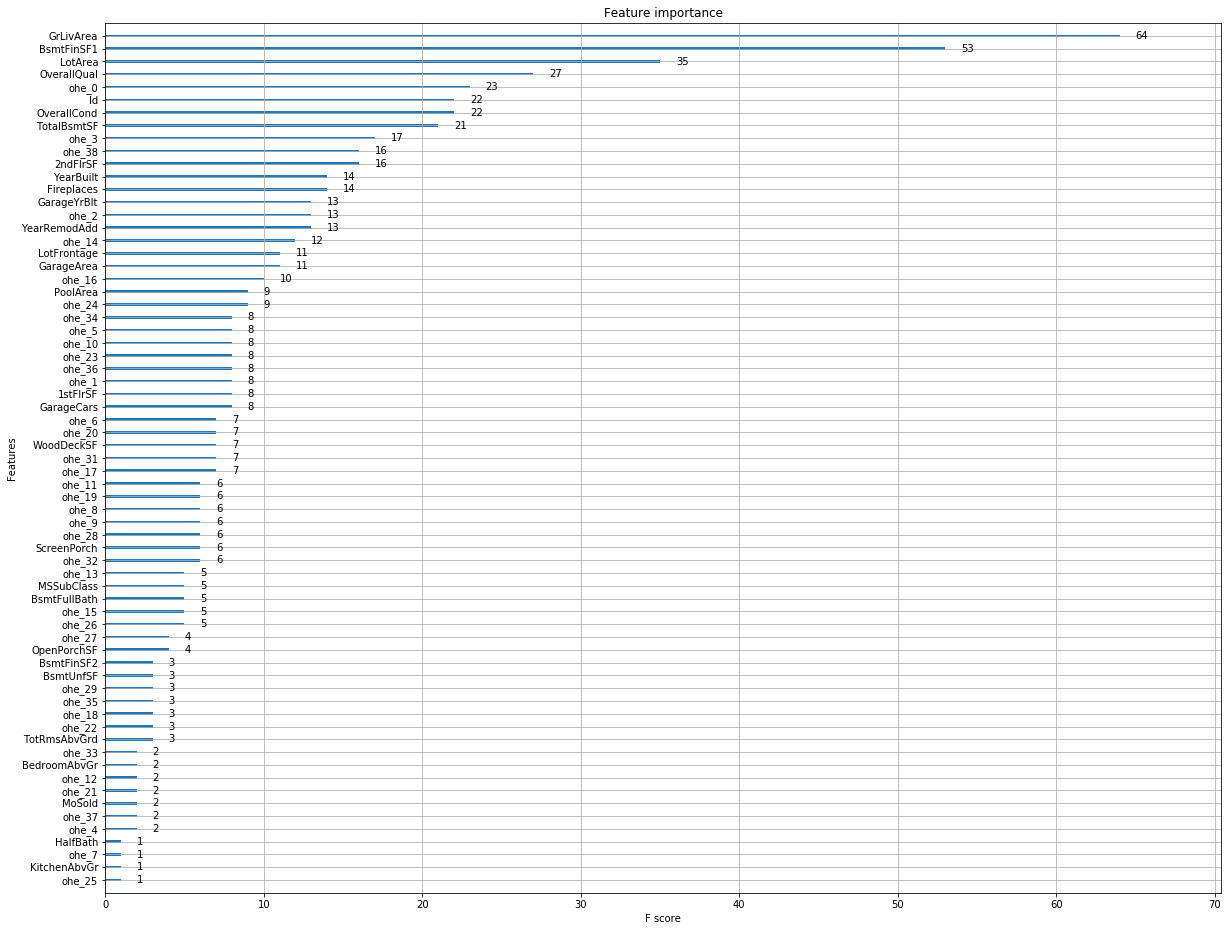

In [34]:
print(model.feature_importances_)

fig, ax = plt.subplots(1,1,figsize=(20,16))
plot_importance(model, ax=ax)

### Feature Selection with XGBoost Feature Importance Scores

This is done using the SelectFromModel class that takes a model and can transform a dataset into a subset with selected features.

This class can take a pre-trained model, such as one trained on the entire training dataset. It can then use a threshold to decide which features to select. This threshold is used when you call the transform() method on the SelectFromModel instance to consistently select the same features on the training dataset and the test dataset.

In [35]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(onehot_housing_X_train_pca)
    
    # train model
    selection_model = XGBRegressor()
    selection_model.fit(select_X_train, housing_y_train)
    
    # eval model
    select_X_test = selection.transform(onehot_housing_X_test_pca)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    r2Score = r2_score(housing_y_test, predictions)
    print("Thresh=%.3f, n=%d, R2 Score: %.2f%%" % (thresh, select_X_train.shape[1], r2Score*100.0))

Thresh=0.000, n=76, R2 Score: 87.71%
Thresh=0.000, n=76, R2 Score: 87.71%
Thresh=0.000, n=76, R2 Score: 87.71%
Thresh=0.000, n=76, R2 Score: 87.71%
Thresh=0.000, n=76, R2 Score: 87.71%
Thresh=0.000, n=76, R2 Score: 87.71%
Thresh=0.000, n=76, R2 Score: 87.71%
Thresh=0.000, n=76, R2 Score: 87.71%
Thresh=0.000, n=76, R2 Score: 87.71%
Thresh=0.002, n=67, R2 Score: 87.71%
Thresh=0.002, n=67, R2 Score: 87.71%
Thresh=0.002, n=67, R2 Score: 87.71%
Thresh=0.002, n=67, R2 Score: 87.71%
Thresh=0.003, n=63, R2 Score: 87.31%
Thresh=0.003, n=63, R2 Score: 87.31%
Thresh=0.003, n=63, R2 Score: 87.31%
Thresh=0.003, n=63, R2 Score: 87.31%
Thresh=0.003, n=63, R2 Score: 87.31%
Thresh=0.003, n=63, R2 Score: 87.31%
Thresh=0.003, n=63, R2 Score: 87.31%
Thresh=0.005, n=56, R2 Score: 89.07%
Thresh=0.005, n=56, R2 Score: 89.07%
Thresh=0.005, n=56, R2 Score: 89.07%
Thresh=0.005, n=56, R2 Score: 89.07%
Thresh=0.005, n=56, R2 Score: 89.07%
Thresh=0.005, n=56, R2 Score: 89.07%
Thresh=0.005, n=56, R2 Score: 89.07%
T

__So the threshold of 0.005 looks to perform the best, with 56 features.__

_Select the required features_

In [36]:
# select features using threshold
selection = SelectFromModel(model, threshold=0.004, prefit=True)

select_X_train = selection.transform(onehot_housing_X_train_pca)
select_X_test = selection.transform(onehot_housing_X_test_pca)

print(select_X_train.shape)
print(select_X_test.shape)

(1168, 56)
(292, 56)


### How to Configure Gradient Boosting

A good general configuration strategy is as follows:

1. Run the default configuration and review plots of the learning curves on the training and validation datasets.
2. If the system is overlearning, decrease the learning rate and/or increase the number of trees.
3. If the system is underlearning, speed the learning up to be more aggressive by increasing the learning rate and/or decreasing the number of trees.

A trick is to set the number of trees to a target value such as 100 or 1000, then tune the learning rate to find the best model. This is an efficient strategy for quickly finding a good model.

### XGBoost Hyperparameter Tuning

This is the best practice when applying XGBoost to your own problems. The parameters to consider tuning are:

- The number and size of trees (n_estimators and max_depth).
- The learning rate and number of trees (learning_rate and n_estimators).
- The row and column subsampling rates (subsample, colsample_bytree and colsample_bylevel).

In [37]:
n_estimators = [50, 100, 150, 200, 300, 400]
max_depth = [2, 3, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="r2", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(select_X_train, housing_y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/Users/samyam/anaconda3/envs/deeplog/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished


In [38]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.782595 using {'max_depth': 2, 'n_estimators': 400}
0.725809 (0.102952) with: {'max_depth': 2, 'n_estimators': 50}
0.761631 (0.087280) with: {'max_depth': 2, 'n_estimators': 100}
0.773180 (0.080033) with: {'max_depth': 2, 'n_estimators': 150}
0.777867 (0.077787) with: {'max_depth': 2, 'n_estimators': 200}
0.782044 (0.072635) with: {'max_depth': 2, 'n_estimators': 300}
0.782595 (0.072240) with: {'max_depth': 2, 'n_estimators': 400}
0.754768 (0.103053) with: {'max_depth': 3, 'n_estimators': 50}
0.768242 (0.102588) with: {'max_depth': 3, 'n_estimators': 100}
0.770321 (0.097720) with: {'max_depth': 3, 'n_estimators': 150}
0.771564 (0.097354) with: {'max_depth': 3, 'n_estimators': 200}
0.773728 (0.094638) with: {'max_depth': 3, 'n_estimators': 300}
0.773981 (0.095437) with: {'max_depth': 3, 'n_estimators': 400}
0.750757 (0.112001) with: {'max_depth': 4, 'n_estimators': 50}
0.758847 (0.108223) with: {'max_depth': 4, 'n_estimators': 100}
0.760862 (0.106014) with: {'max_depth': 4, 'n_es

Based on the Grid search results, 'max_depth': 3, 'n_estimators': 400 looks to perform best. 
Implementing the same below.

In [39]:
model = XGBRegressor(max_depth=3, n_estimators=400)
model.fit(select_X_train, housing_y_train)
housing_y_test_pred=model.predict(select_X_test) 

## Evaluate model

#### Mean Absolute Error
The Mean Absolute Error (or MAE) is the sum of the absolute differences between predictions and actual values. It gives an idea of how wrong the predictions were.

The measure gives an idea of the magnitude of the error, but no idea of the direction (e.g. over or under predicting).

In [40]:
mae_score = mean_absolute_error(housing_y_test, housing_y_test_pred)
mae_score

17174.388678563784

The MAE is quite high, but lets look at the range of target variable to understand better.
Range:-

In [41]:
print("The target variable ranges from min : %.2f to %.2f" %(min(housing_y_test['SalePrice']),max(housing_y_test['SalePrice'])))

The target variable ranges from min : 35311.00 to 755000.00


The target value range is quite high as compared to mae_score, so the model looks to perform well.

#### Mean Squared Error
The Mean Squared Error (or MSE) is much like the mean absolute error in that it provides a gross idea of the magnitude of error.

Taking the square root of the mean squared error converts the units back to the original units of the output variable and can be meaningful for description and presentation. This is called the Root Mean Squared Error (or RMSE).

In [42]:
# The root mean squared error
print("Root Mean squared error: %.2f"% sqrt(mean_squared_error(housing_y_test, housing_y_test_pred)))

Root Mean squared error: 29098.36


The target value range is quite high as compared to mae_score, so the model looks to perform well.

#### R2 score

The R^2 (or R Squared) metric provides an indication of the goodness of fit of a set of predictions to the actual values. In statistical literature, this measure is called the coefficient of determination.

This is a value between 0 and 1 for no-fit and perfect fit respectively.

In [43]:
r2_sco = r2_score(housing_y_test, housing_y_test_pred)
r2_sco

0.88961165245070606

#### Adjusted R2

In [44]:
num_observations = housing_y_test.shape[0]
num_independent_var = housing_X_train.shape[1]
adj_r2_sco = 1 - ((1- r2_sco)*((num_observations - 1 )/(num_observations - num_independent_var - 1)))
adj_r2_sco

0.85059065517746724

__OverAll the model looks to perform well.__

___Will convering the feature set to normal distribution improve performance?___

## Reference

1. https://machinelearningmastery.com/xgboost-python-mini-course/
2. https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
3. https://data-flair.training/blogs/what-is-xgboost/
4. http://scikit-learn.org/stable/modules/model_evaluation.html
5. https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/
6. https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/